In [1]:
import pandas as pd
data2020 = pd.read_csv('../data/2020/survey_results_public.csv')

language2020 = data2020[['LanguageWorkedWith', 'LanguageDesireNextYear']]
database2020 = data2020[['DatabaseWorkedWith', 'DatabaseDesireNextYear']]
misctech2020 = data2020[['MiscTechWorkedWith', 'MiscTechDesireNextYear']]
colbtool2020 = data2020[['NEWCollabToolsWorkedWith', 'NEWCollabToolsDesireNextYear']]
platform2020 = data2020[['PlatformWorkedWith', 'PlatformDesireNextYear']]
webframe2020 = data2020[['WebframeWorkedWith', 'WebframeDesireNextYear']]

可以检视一下这些数据，其中包含缺失值，但对于词频统计来说，填补是没有必要的，我们只是为了找到舆论上热度最高的那些。

In [2]:
language2020.head().values.tolist()

[['C#;HTML/CSS;JavaScript', 'C#;HTML/CSS;JavaScript'],
 ['JavaScript;Swift', 'Python;Swift'],
 ['Objective-C;Python;Swift', 'Objective-C;Python;Swift'],
 [nan, nan],
 ['HTML/CSS;Ruby;SQL', 'Java;Ruby;Scala']]

In [3]:
from collections import Counter

def count_freq(data: pd.Series):
    return Counter([item for record in data.dropna().values for item in record.split(';')])


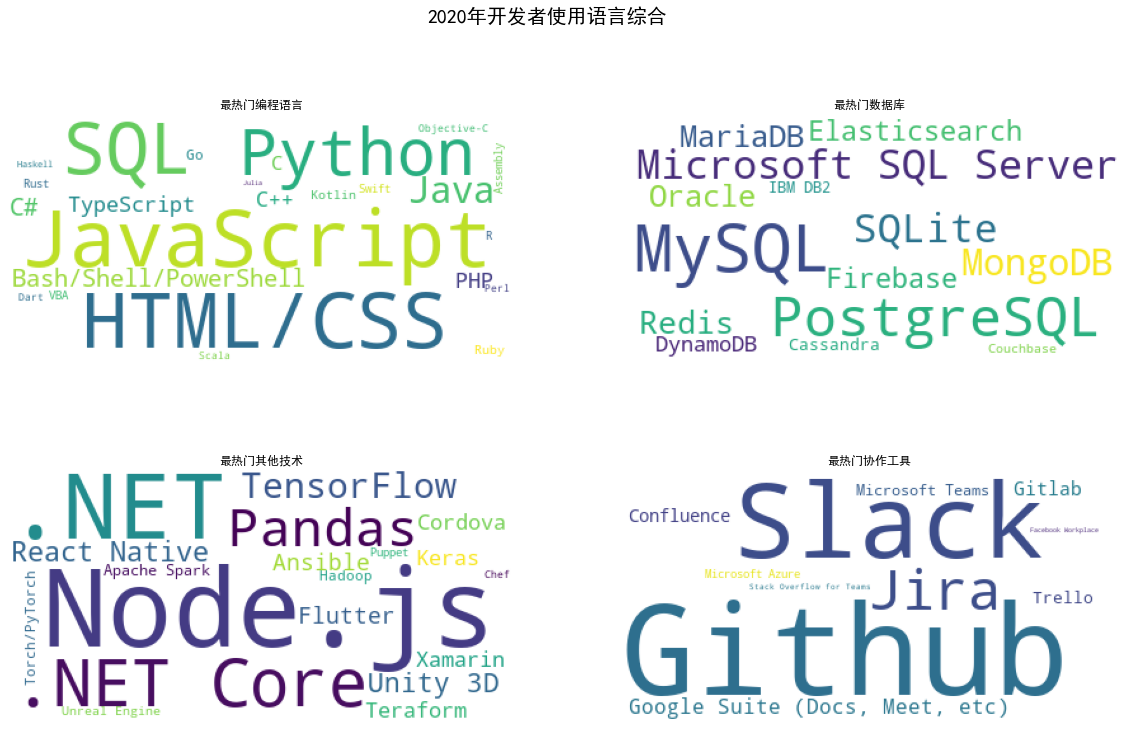

In [4]:
from wordcloud import WordCloud
from PIL import Image
import numpy as np

from matplotlib import pyplot as plt


# 统计2020年所有开发者使用语言的综合，找出最为热门的语言
wc = WordCloud(background_color='white')

plt.figure(figsize=(20, 12))
plt.suptitle('2020年开发者使用语言综合', fontsize=20)

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plt.subplot(2,2,1)
wc.generate_from_frequencies(count_freq(language2020['LanguageWorkedWith']))
plt.imshow(wc)
plt.axis("off")
plt.title('最热门编程语言')

plt.subplot(2,2,2)
wc.generate_from_frequencies(count_freq(database2020['DatabaseWorkedWith']))
plt.imshow(wc)
plt.axis("off")
plt.title('最热门数据库')

plt.subplot(2,2,3)
wc.generate_from_frequencies(count_freq(misctech2020['MiscTechWorkedWith']))
plt.imshow(wc)
plt.axis("off")
plt.title('最热门其他技术')

plt.subplot(2,2,4)
wc.generate_from_frequencies(count_freq(colbtool2020['NEWCollabToolsWorkedWith']))
plt.imshow(wc)
plt.axis("off")
plt.title('最热门协作工具')

plt.show()


接下来我们将上述得到的词表进行汇总，将从reddit上得到的语料进行词频统计。

In [5]:
with open('assets/vocabulary.txt', 'r', encoding='utf-8') as f:
    vocabulary = set(f.read().split('\n'))

for col in data2020[['LanguageWorkedWith', 'LanguageDesireNextYear',
      'DatabaseWorkedWith', 'DatabaseDesireNextYear',
      'MiscTechWorkedWith', 'MiscTechDesireNextYear',
      'NEWCollabToolsWorkedWith', 'NEWCollabToolsDesireNextYear',
      'PlatformWorkedWith', 'PlatformDesireNextYear',
      'WebframeWorkedWith', 'WebframeDesireNextYear']].columns:
      vocabulary.update(set(count_freq(data2020[col]).keys()))

with open('assets/vocabulary.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(vocabulary))


上述经由调查选项的词表非常有限，我们需要建立同义词表，同时在后续工作中根据结果及时手动添加比较显著的新词。

下面的代码添加了大小写同义。

In [6]:
import json

with open('assets/syno_dict.json', 'r', encoding='utf-8') as f:
    syno_dict = json.load(f)

for word in vocabulary:
    # 首先添加大小写同义
    if word not in syno_dict:
        syno_dict[word.lower()] = word
    
    # 随后添加斜杠隔开的多项
    if '/' in word:
        for item in word.split('/'):
            syno_dict[item.lower()] = word

with open('assets/syno_dict.json', 'w', encoding='utf-8') as f:
    json.dump(syno_dict, f, ensure_ascii=False, indent=4)

词频统计，利用停用词方式，进行初步的词频统计，从而进一步人工查找相关话题词表。

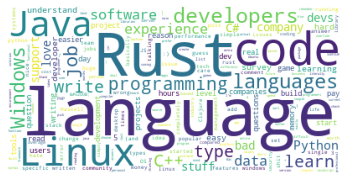

In [7]:
import os
import json

with open('assets/stopwords.txt', 'r', encoding='utf-8') as f:
    stopwords = set(f.read().split('\n'))

counter = Counter()
for root, dirs, files in os.walk('../data/comments'):
    for file in files:
        data = pd.read_csv(os.path.join(root, file))
        if 'comment_text' not in data.columns:
            continue
        for comment in data['comment_text']:
            counter += Counter([word for word in comment.split() if word.lower() not in stopwords and not word.endswith((',', '.', '!', '?'))])
        print(file, end='\r', flush=True)

wc = WordCloud(background_color='white')
wc.generate_from_frequencies(counter)

plt.imshow(wc)
plt.axis("off")
plt.show()

with open('assets/word_freq.json', 'w', encoding='utf-8') as f:
    json.dump(counter.most_common(), f, ensure_ascii=False, indent=4)

In [10]:
from nltk import word_tokenize

counter = Counter()
for root, dirs, files in os.walk('../data/comments'):
    for file in files:
        data = pd.read_csv(os.path.join(root, file))
        if 'comment_text' not in data.columns:
            continue
        for comment in data['comment_text']:
            words = [word.lower() for word in word_tokenize(comment)]
            words = [syno_dict[word] for word in words if word in syno_dict]
            counter += Counter(words)
        print(file, end='\r', flush=True)

In [12]:
counter.most_common(20)

[('Rust', 1642),
 ('Linux', 1228),
 ('Java', 1070),
 ('Windows', 953),
 ('Go', 945),
 ('C', 938),
 ('Python', 798),
 ('C++', 637),
 ('JavaScript', 408),
 ('Haskell', 267),
 ('Clojure', 262),
 ('TypeScript', 259),
 ('PHP', 245),
 ('Bash/Shell/PowerShell', 207),
 ('Mac', 190),
 ('Ruby', 186),
 ('.NET', 186),
 ('Ubuntu', 186),
 ('Scala', 137),
 ('Apple', 130)]

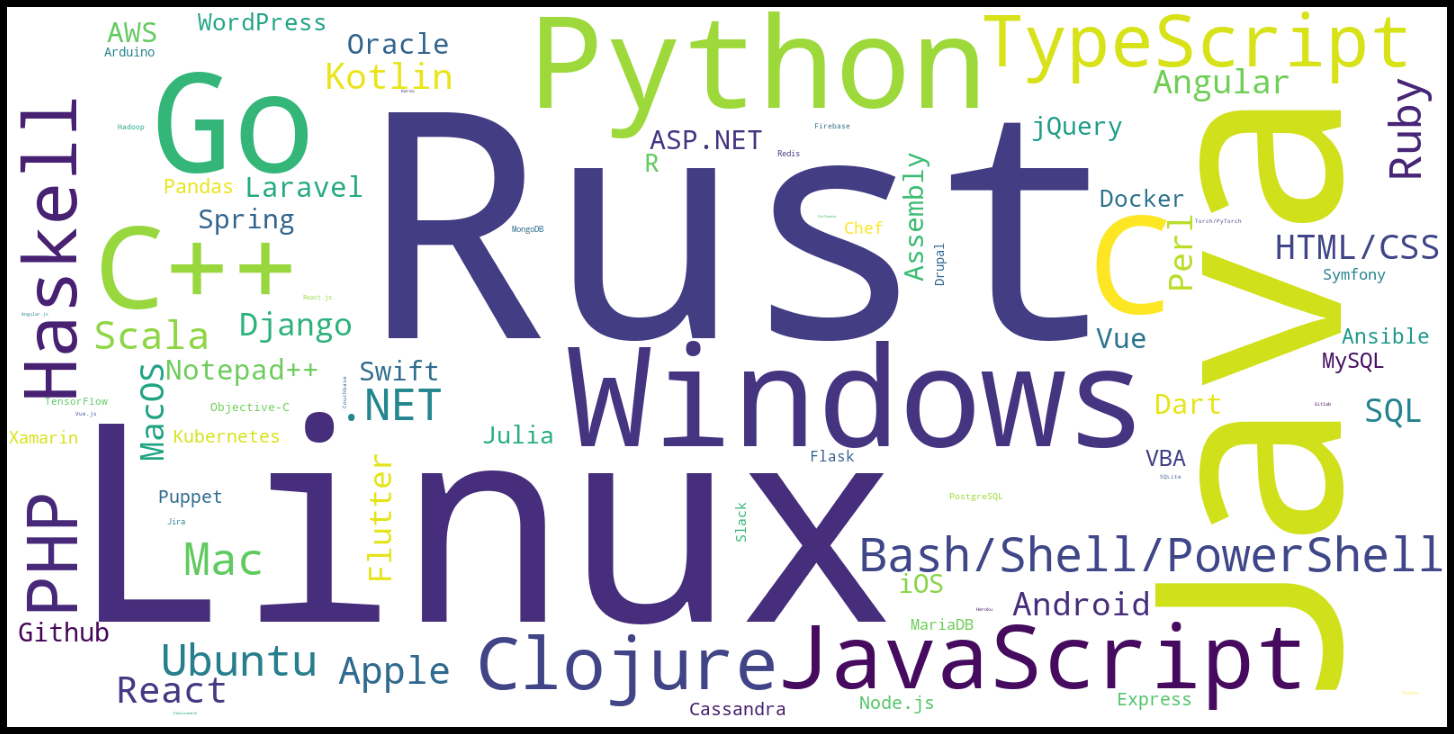

In [11]:
wc = WordCloud(background_color='white', width=1600, height=800)
wc.generate_from_frequencies(counter)

plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()